In [ ]:
!git clone https://github.com/huggingface/transformers.git 

fatal: destination path 'transformers' already exists and is not an empty directory.


In [ ]:
!mkdir -p megatron/nvidia/megatron-bert-cased-345m/

In [ ]:
!wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/megatron_bert_345m/versions/v0.1_cased/zip -O megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip

--2022-06-30 21:16:32--  https://api.ngc.nvidia.com/v2/models/nvidia/megatron_bert_345m/versions/v0.1_cased/zip
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 34.211.245.173, 35.167.154.70
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|34.211.245.173|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://prod-model-registry-ngc-bucket.s3.us-west-2.amazonaws.com/org/nvidia/models/megatron_bert_345m/versions/v0.1_cased/files.zip?response-content-disposition=attachment%3B%20filename%3D%22files.zip%22&response-content-type=application%2Fzip&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEA0aCXVzLXdlc3QtMiJGMEQCIG5oVaT6hGa0PgCa12iuojZMotDR4kj8nQLftOPaW6GeAiBEg8wA1obF9j37Cvza63d8uATbrAwKkci47TqFSbdKHSrSBAg2EAQaDDc4OTM2MzEzNTAyNyIMRLIXKYNSLr1KUXd0Kq8EAoi7UqOTPYgrSN4EHQrR2kjVu%2FvvxCM4kc7FAoYUHngnNNrhAufYzCmMRHT1tBWlW7i%2BQj2iQiwOo8h89rcLFkgomVIz%2B3k8M96lJ8ofVEw67Py1IFKFtsOsypxy3FKmpHsZN%2BTsxzAVGIF4NJYqyby5vaPiufbWf3JtyUZ6CgpF3KeNKZAkm%2ByAUVY%2FYYThgbbHGYsuieO%

In [ ]:
!pip install transformers tokenizers
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-8zxp6g6r
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-8zxp6g6r
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
!python3 transformers/src/transformers/models/megatron_bert/convert_megatron_bert_checkpoint.py megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip

Extracting PyTorch state dictionary from "megatron/nvidia/megatron-bert-cased-345m/checkpoint.zip"
Converting
Saving config
Saving checkpoint to "megatron/nvidia/megatron-bert-cased-345m/pytorch_model.bin"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import pytorch_lightning as pl

from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, MegatronBertModel, MegatronBertConfig, BertTokenizer, MegatronBertForSequenceClassification, MegatronBertForMaskedLM
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

from typing import Dict, List, Tuple

import logging
import copy
import os
import sys
import gc
import random
from functools import lru_cache
from argparse import Namespace
from packaging import version
from tqdm.autonotebook import tqdm

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:

_CITATION = '''
@inproceedings{rashkin2019towards,
  title = {Towards Empathetic Open-domain Conversation Models: a New Benchmark and Dataset},
  author = {Hannah Rashkin and Eric Michael Smith and Margaret Li and Y-Lan Boureau},
  booktitle = {ACL},
  year = {2019},
}
'''

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_train_equal.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_test_equal.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/my_emp_dia_val_equal.txt"

In [ ]:
labels = [ "sadness", "joy", "anger", "fear", "love", "instability", "disgust", "disappointment", "shame", "guilt", "envy"]
label2int = dict(zip(labels, list(range(len(labels)))))

In [ ]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(21)

In [ ]:
#load actual model
model = MegatronBertModel.from_pretrained("megatron/nvidia/megatron-bert-cased-345m")

Some weights of the model checkpoint at megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#define an EmoClassificationModel class to do the actual fine-tuning

class EmoClassificationModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=1024, dropout=0.05):
        super().__init__()
        self.base_model = base_model
        
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            nn.Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )
        
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        
        return self.classifier(hidden_states[0][:, 0, :])

Now some dataset preparation for the fine-tuning process.

In [ ]:
class CollateFn:
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("nvidia/megatron-bert-cased-345m")

    def __call__(self, batch):
        inputs = list(x[0] for x in batch)
        encoded = self.tokenizer(inputs, padding=True)
        sequences_padded = torch.tensor([ids for ids in encoded['input_ids']])
        attention_masks_padded = torch.tensor([masks for masks in encoded['attention_mask']])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

In [ ]:
#class to create dataset objects from the data

class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoClassificationModel(MegatronBertModel.from_pretrained("megatron/nvidia/megatron-bert-cased-345m"), len(labels))
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=CollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW as this usually performs well
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]
   
    def save_model(self):
        torch.save(self.model.state_dict(), '/content/Megatron_finetuned_emp_dia.pt')

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=1,
    seed=21
)
module = TrainingModule(hparams)

Some weights of the model checkpoint at megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train (using cuda)
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | EmoClassificationModel | 334 M 
1 | los

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.7286    0.7727    0.7500        66
           joy     0.8413    0.8030    0.8217        66
         anger     0.6818    0.6818    0.6818        66
          fear     0.8028    0.8636    0.8321        66
          love     0.8154    0.8030    0.8092        66
   instability     0.7606    0.8182    0.7883        66
       disgust     0.8143    0.8636    0.8382        66
disappointment     0.7031    0.6818    0.6923        66
         shame     0.6286    0.6667    0.6471        66
         guilt     0.7143    0.6818    0.6977        66
          envy     0.9245    0.7424    0.8235        66

      accuracy                         0.7617       726
     macro avg     0.7650    0.7617    0.7620       726
  weighted avg     0.7650    0.7617    0.7620       726



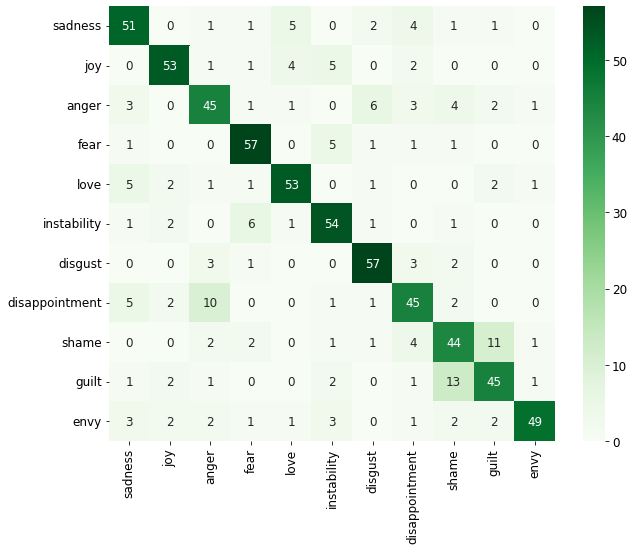

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');

ine tune on Crowd-Sourced data

In [ ]:
train_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_train_equal_no_jealous.txt"
test_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_test_equal_no_jealous.txt"
val_path = "drive/MyDrive/Individual Project/Data/Emotion/bt_val_equal_no_jealous.txt"

In [ ]:
class TrainingModule(pl.LightningModule):
    def __init__(self, hparams, model):
        super().__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters(hparams)

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    num_workers = 4,
                    shuffle=shuffle,
                    collate_fn=CollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr) #we use AdamW 
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def save_model(self):
        torch.save(self.model.state_dict(), '/content/Megatron_double_finetuned_emp_dia.pt')

In [ ]:
model = EmoClassificationModel(MegatronBertModel.from_pretrained("megatron/nvidia/megatron-bert-cased-345m"), len(labels))
device = torch.device('cuda:0')
model.load_state_dict(torch.load('/content/Megatron_finetuned_emp_dia.pt'))
model.to(device)

Some weights of the model checkpoint at megatron/nvidia/megatron-bert-cased-345m were not used when initializing MegatronBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing MegatronBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MegatronBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EmoClassificationModel(
  (base_model): MegatronBertModel(
    (embeddings): MegatronBertEmbeddings(
      (word_embeddings): Embedding(29056, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): MegatronBertEncoder(
      (layer): ModuleList(
        (0): MegatronBertLayer(
          (attention): MegatronBertAttention(
            (ln): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (self): MegatronBertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MegatronBertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=10,
    lr=5E-05,
    accumulate_grad_batches=2
)
module = TrainingModule(hparams, model)

In [ ]:
#rubbish collection
gc.collect()
torch.cuda.empty_cache()

####Now we can fine-tune

In [ ]:
#train
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:440: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                   | Params
-------------------------------------------------
0 | model | EmoClassificationModel | 334 M 
1 | los

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
module.save_model()

##Evaluation on the held-out test

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval().cuda()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        batch = (X.cuda(), attn.cuda())
        print(progress[i % len(progress)], end="\r")
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=4))


________________________________________________________________________________
                precision    recall  f1-score   support

       sadness     0.7391    0.7727    0.7556        22
           joy     0.9500    0.9048    0.9268        21
         anger     0.8421    0.7619    0.8000        21
          fear     0.9615    0.9615    0.9615        26
          love     1.0000    0.9600    0.9796        25
   instability     0.8333    0.9615    0.8929        26
       disgust     0.9167    0.9167    0.9167        24
disappointment     0.9655    0.9032    0.9333        31
         shame     0.9565    1.0000    0.9778        22
         guilt     1.0000    0.9444    0.9714        18
          envy     0.9643    1.0000    0.9818        27

      accuracy                         0.9202       263
     macro avg     0.9208    0.9170    0.9179       263
  weighted avg     0.9223    0.9202    0.9203       263



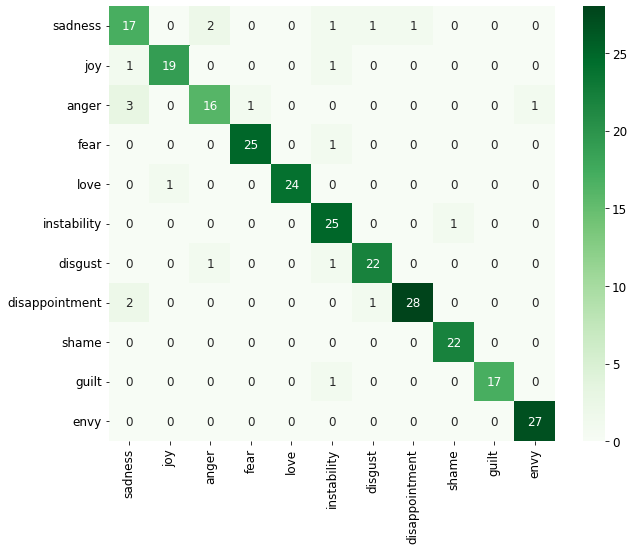

In [ ]:
#plot confusion matrix

cm = confusion_matrix(true_y, pred_y, labels=range(len(labels)))
df_cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.rcParams.update({'font.size': 12}) 
plt.figure(figsize = (10,8));
sn.heatmap(df_cm, annot=True, cmap='Greens', fmt='g');